## Get a frame stream from a merlin detector

If you want to use this with the simulated data source, run something like this in the background:

`libertem-live-mib-sim ~/Data/default.hdr --cached=MEM`

On Linux, `MEMFD` is also supported as a cache. Use `NONE` to deactivate the cache.

* Make sure to adjust the `SCAN_SIZE` below to match the scan of the data source!

In [1]:
# set this to the host/port where the merlin data server is listening:
MERLIN_DATA_SOCKET = ('127.0.0.1', 6342)

In [2]:
%matplotlib nbagg

In [3]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from libertem_live.detectors.merlin import MerlinDataSource

In [5]:
data_source = MerlinDataSource(host=MERLIN_DATA_SOCKET[0], port=MERLIN_DATA_SOCKET[1], pool_size=3)

In [6]:
result = np.zeros((256, 256), dtype=np.float32)

In [7]:
for frames in data_source.stream(chunk_size=128):
    result += frames.buf.sum(axis=0)

<IPython.core.display.Javascript object>


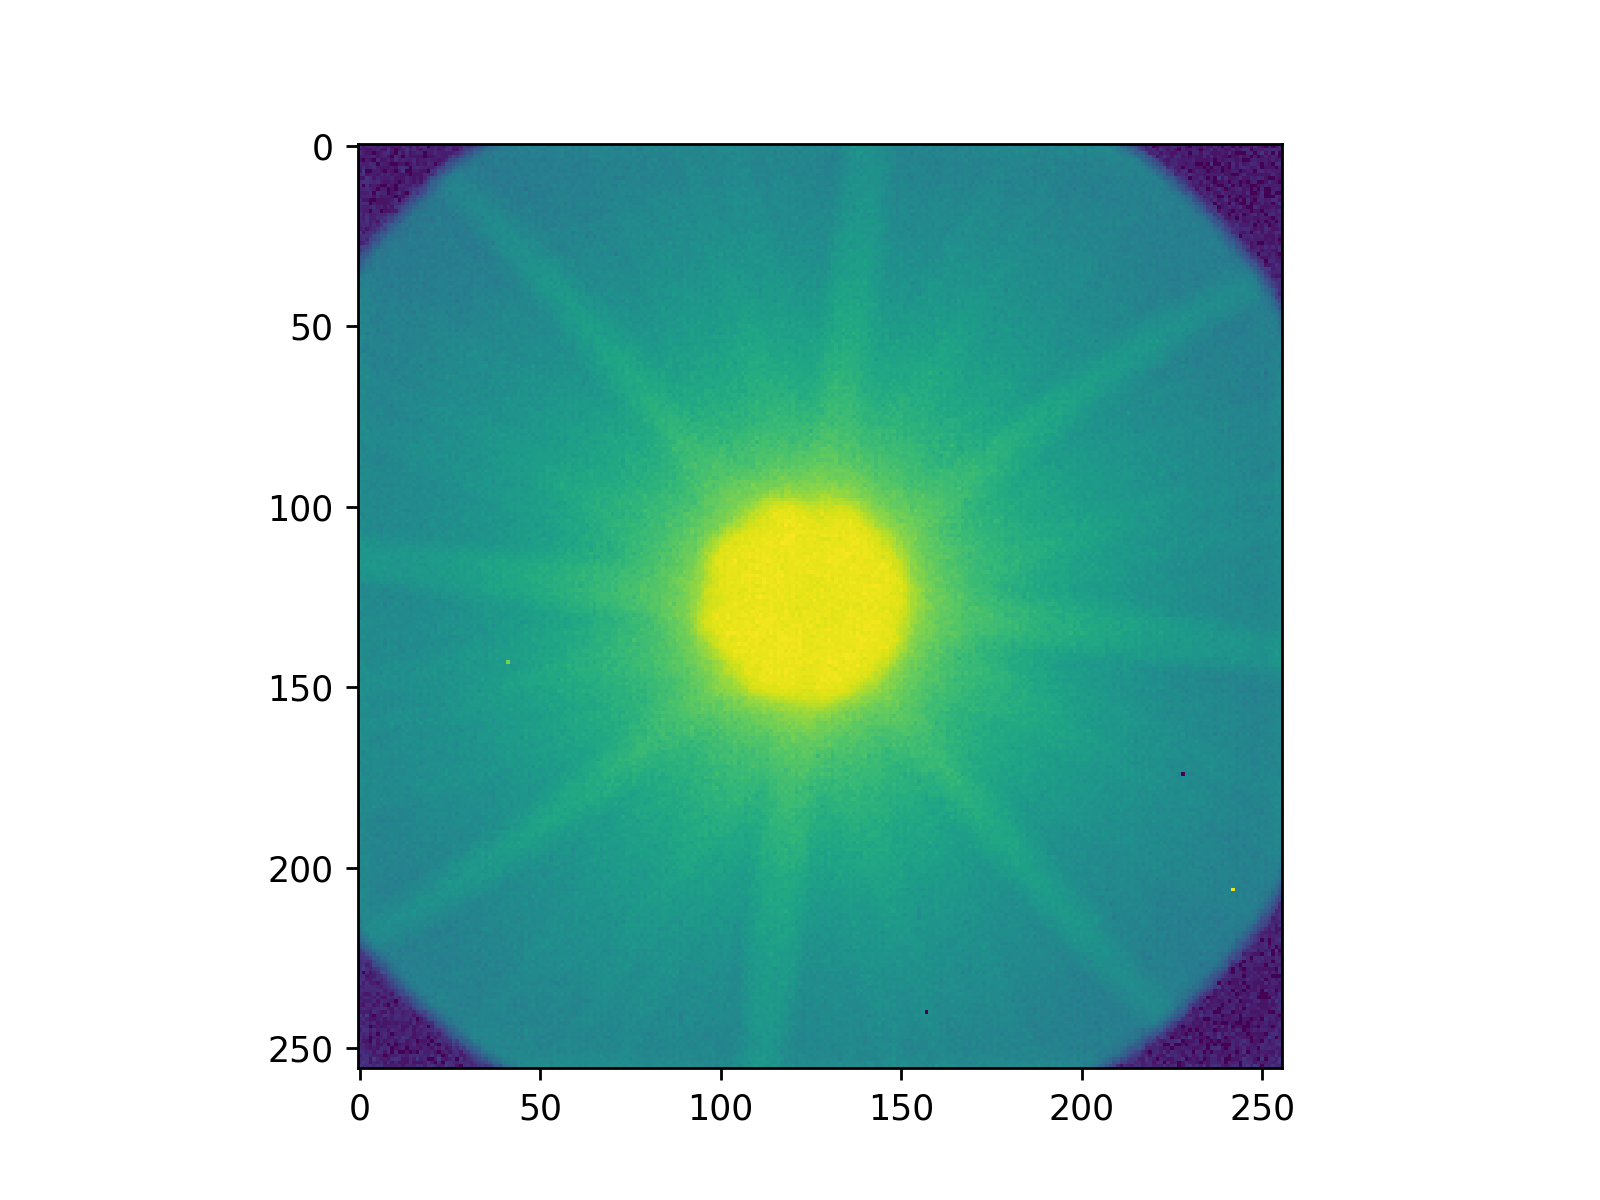

In [8]:
ax, fig = plt.subplots()
fig.imshow(np.log1p(result))